# REINFORCEMENT LEARNING

### Author: Hyungjoo Kim

##### All data was provided by University College London, Department of Computer Science, Reinforcement Learning Module

##### Supervisor: Prof. Hado Van Hasselt, Matteo Hessel, and Diana Borsa

**Context**

In this assignment, we will take a first look at learning algorithms for sequential decision problems.

**Background reading**

* Sutton and Barto (2018), Chapters 3 - 6

**Overview of this assignment**

You will use Python to implement several reinforcement learning algorithms.

You will then run these algorithms on a few problems, to understand their properties.

# Setup

### Import Useful Libraries

In [1]:
import matplotlib.collections as mcoll
import matplotlib.path as mpa
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [2]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-colorblind')

### Some grid worlds

In [3]:
W = -100  # wall
G = 100  # goal

GRID_LAYOUT = np.array([
  [W, W, W, W, W, W, W, W, W, W, W, W],
  [W, W, 0, W, W, W, W, W, W, 0, W, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, G, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, W, 0, 0, 0, 0, 0, 0, 0, 0, W, W],
  [W, W, W, W, W, W, W, W, W, W, W, W]
])

class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = GRID_LAYOUT
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states

  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(self, obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    reward = self._layout[new_y, new_x]
    if self._layout[new_y, new_x] == W:  # wall
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = -1.
      discount = 0.9
    else:  # a goal
      discount = 0.
      new_state = self._start_state

    if self._noisy:
      width = self._layout.shape[1]
      reward += 10*np.random.normal(0, width - new_x + new_y)

    self._state = new_state
    return reward, discount, self.get_obs()

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != W, interpolation="nearest", cmap='pink')
    plt.gca().grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(9, 2, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

In [4]:
SMALL_GRID_LAYOUT = np.array([
  [W, W, W, W, W],
  [W, W, 3, W, W],
  [W, W, 0, W, W],
  [W, 1, 0, W, W],
  [W, W, 0, W, W],
  [W, W, 0, 4, W],
  [W, W, W, W, W]
])


def plot_small_grid(version=1):
  plt.imshow(SMALL_GRID_LAYOUT < -1, interpolation='nearest', cmap='pink_r',
             vmin=-0.2, vmax=1.2)
  if version == 1:
    plt.text(2, 1, '$+3$', ha='center', va='center', fontsize=12)
    plt.text(1, 3, '$+1$', ha='center', va='center', fontsize=12)
    plt.text(3, 5, '$+4$', ha='center', va='center', fontsize=12)
  else:
    plt.text(2, 1, '$+2$', ha='center', va='center', fontsize=12)
    plt.text(1, 3, '$+1$', ha='center', va='center', fontsize=12)
    plt.text(3, 5, '$+5$', ha='center', va='center', fontsize=12)
  plt.text(2, 3, '$S$', ha='center', va='center', fontsize=12)
  h, w = SMALL_GRID_LAYOUT.shape
  for r in np.arange(0.5, h):
    plt.plot([-0.5, w - 0.5], [r, r], '-k', lw=3, alpha=0.4)
  for c in np.arange(0.5, w):
    plt.plot([c, c], [-0.5, h - 0.5], '-k', lw=3, alpha=0.4)
  plt.xticks([]); plt.yticks([]);

### Helper functions
(You should not have to change, or even look at, these.  Do run the cell to make sure the functions are loaded though.)

In [5]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += reward
    return mean_reward/float(number_of_steps)

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(grid, values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values - 1000*(grid<0), interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(grid, action_values, vmin=-5, vmax=5):
  q = action_values
  fig = plt.figure(figsize=(10, 10))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(4, 3, map_from_action_to_subplot(a))
    plot_values(grid, q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(4, 3, 5)
  v = np.max(q, axis=-1)
  plot_values(grid, v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
  
  # Plot arrows:
  plt.subplot(4, 3, 11)
  plot_values(grid, grid==0, vmax=1)
  for row in range(len(grid)):
    for col in range(len(grid[0])):
      if grid[row][col] == 0:
        argmax_a = np.argmax(q[row, col])
        if argmax_a == 0:
          x = col
          y = row + 0.5
          dx = 0
          dy = -0.8
        if argmax_a == 1:
          x = col - 0.5
          y = row
          dx = 0.8
          dy = 0
        if argmax_a == 2:
          x = col
          y = row - 0.5
          dx = 0
          dy = 0.8
        if argmax_a == 3:
          x = col + 0.5
          y = row
          dx = -0.8
          dy = 0
        plt.arrow(x, y, dx, dy, width=0.02, head_width=0.4, head_length=0.4, length_includes_head=True, fc='k', ec='k')

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])


def colorline(x, y, z):
    """
    Based on:
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """
    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=plt.get_cmap('copper_r'),
                              norm=plt.Normalize(0.0, 1.0), linewidth=3)

    ax = plt.gca()
    ax.add_collection(lc)
    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def plotting_helper_function(_x, _y, title=None, ylabel=None):
  z = np.linspace(0, 0.9, len(_x))**0.7
  colorline(_x, _y, z)
  plt.plot(0, 0, '*', color='#000000', ms=20, alpha=0.7, label='$w^*$')
  plt.plot(1, 1, '.', color='#ee0000', alpha=0.7, ms=20, label='$w_0$')
  min_y, max_y = np.min(_y), np.max(_y)
  min_x, max_x = np.min(_x), np.max(_x)
  min_y, max_y = np.min([0, min_y]), np.max([0, max_y])
  min_x, max_x = np.min([0, min_x]), np.max([0, max_x])
  range_y = max_y - min_y
  range_x = max_x - min_x
  max_range = np.max([range_y, range_x])
  plt.arrow(_x[-3], _y[-3], _x[-1] - _x[-3], _y[-1] - _y[-3], color='k',
            head_width=0.04*max_range, head_length=0.04*max_range,
            head_starts_at_zero=False)
  plt.ylim(min_y - 0.2*range_y, max_y + 0.2*range_y)
  plt.xlim(min_x - 0.2*range_x, max_x + 0.2*range_x)
  ax = plt.gca()
  ax.ticklabel_format(style='plain', useMathText=True)
  plt.legend(loc=2)
  plt.xticks(rotation=12, fontsize=10)
  plt.yticks(rotation=12, fontsize=10)
  plt.locator_params(nbins=3)
  if title is not None:
    plt.title(title, fontsize=20)
  if ylabel is not None:
    plt.ylabel(ylabel, fontsize=20)

## Task 1 - Implement a general Q-learning agent 
Implement a  **general Q-learning** agent that learns action values from experience.   The agent must act according to an $\epsilon$-greedy policy over its action values.  It must be configurable so as to implement any of **Sarsa**, **Expected Sarsa**, **Q-learning**,  and **double Q-learning**.

The `__init__` must accept two functions `target_policy` and `behaviour_policy` as arguments.   The function `behaviour_policy(action_values)` should map `action_values` to a single action. 

For instance, the random policy can be implemented as:
```
def behaviour_policy(action_values):
  return np.random.randint(len(action_values))
```

The target policy is defined by a function `target_policy(action_values, action)`, which returns **a vector** with one probability per action.  The `action` argument is used for instance by Sarsa (where the target policy is a greedy distribution with its peak on the selected action).

For instance, the random target policy is:
```
def target_policy(action_values, unused_action):
  number_of_actions = len(action_values)
  return np.ones((number_of_actions,))/number_of_actions
```

The `__init__` must also accept  a `double` boolean flag. Note that this is compatible with any choice of `target_policy` and `behaviour_policy`. For instance, if the `target_policy` is the policy described above for Sarsa and `double=True`, the algorithm should implement **double Sarsa**. Note that we then need two action-value functions.

You should be able to use the `__init__` as provided below, so you just have to implement the `step` function.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the update on the first transition in the agent's lifetime.  

In [6]:
class GeneralQ(object):

  def __init__(self, number_of_states, number_of_actions, initial_state,
               target_policy, behaviour_policy, double, step_size=0.1):
    # Settings.
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._target_policy = target_policy
    self._double = double
    # Initial state.
    self._s = initial_state
    # Tabular q-estimates.
    self._q = np.zeros((number_of_states, number_of_actions))
    if double:
      self._q2 = np.zeros((number_of_states, number_of_actions))
    # The first action in an agent's lifetime is always 0(=up) in our setup.
    self._last_action = 0

  @property
  def q_values(self):
    return (self._q + self._q2)/2 if self._double else self._q

  def step(self, reward, discount, next_state):
    # we need to consider two kinds of case, which are SARSA and Q-learning
    # This system implement the random policy, so we need to select two action-value function (q and q')
    # because of the over/under-estimated values as shown in Lecture note 6: Model-Free Control page 29-33
    action = self._behaviour_policy(self.q_values[next_state])
    
    # Define the Double Q-learning
    if self._double == True:
        if np.random.rand() >= 0.5: # For the action-value function q
            self._q[self._s, self._last_action] = self._q[self._s, self._last_action] + self._step_size * (reward + discount * np.dot(self._q2[next_state], self._target_policy(self._q[next_state], action)) - self._q[self._s, self._last_action])

        else:  # For the action-value function q'
            self._q2[self._s, self._last_action] = self._q2[self._s, self._last_action] + self._step_size * (reward + discount * np.dot(self._q[next_state], self._target_policy(self._q2[next_state], action)) - self._q2[self._s, self._last_action])          
            
    else:  # Define SARSA
        self._q[self._s, self._last_action] = self._q[self._s, self._last_action] + self._step_size * (reward + discount * np.dot(self._q[next_state], self._target_policy(self._q[next_state], action)) - self._q[self._s, self._last_action])
     
    # Update the action and new state
    self._last_action = action
    self._s = next_state
    return action

## Experiment 1: Run the cells below

This will train Q-learning, Sarsa, Expected Sarsa, and double Q-learning agents on the deterministic version of the Grid problem.

The agents will be trained  with a step size $\alpha=\frac{1}{10}$ and $\epsilon$-greedy behaviour, with $\epsilon=\frac{1}{4}$.

The plots will show action values for each of the actions, as well as a state value defined by $v(s) = \max_a q(s, a)$.

In [7]:
# Agent settings.
# Do not modify this cell.
epsilon = 0.25
step_size = 0.1

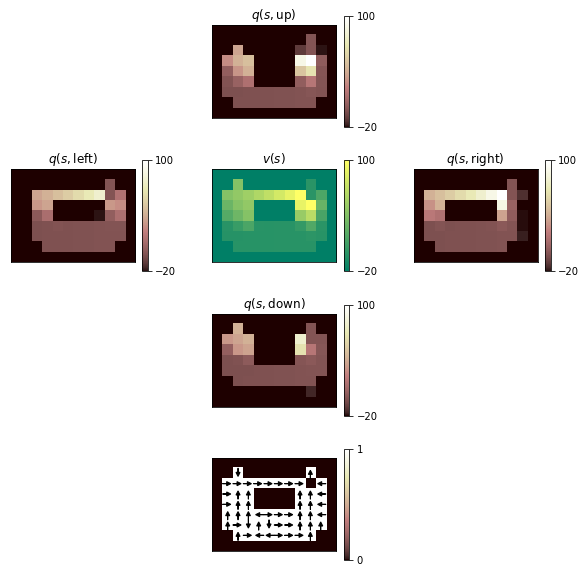

In [8]:
# Q-learning
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  return np.eye(len(q))[np.argmax(q)]

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

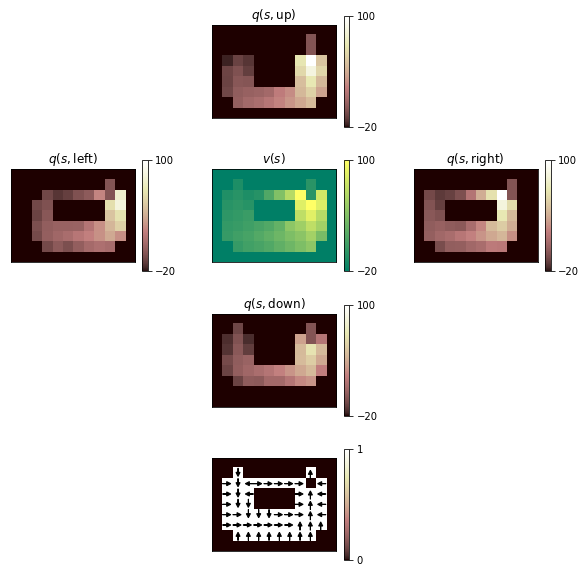

In [9]:
# Sarsa
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  return np.eye(len(q))[a]

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

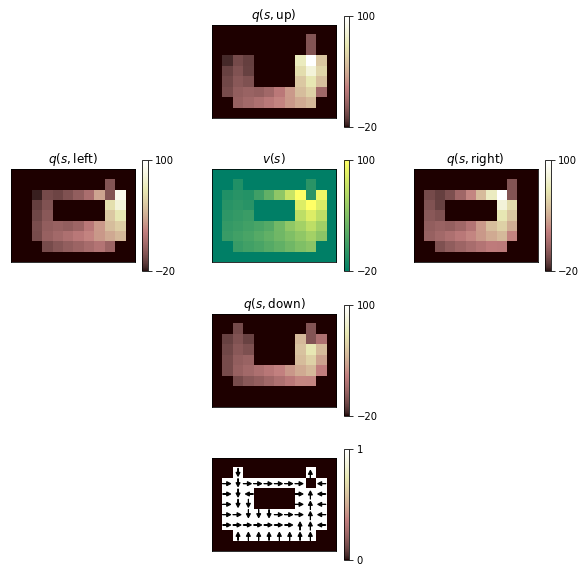

In [10]:
# Expected Sarsa
# Do not modify this cell.
grid = Grid()
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  greedy = np.eye(len(q))[np.argmax(q)]
  return greedy - greedy*epsilon + epsilon/4 

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=False, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-20, vmax=100)

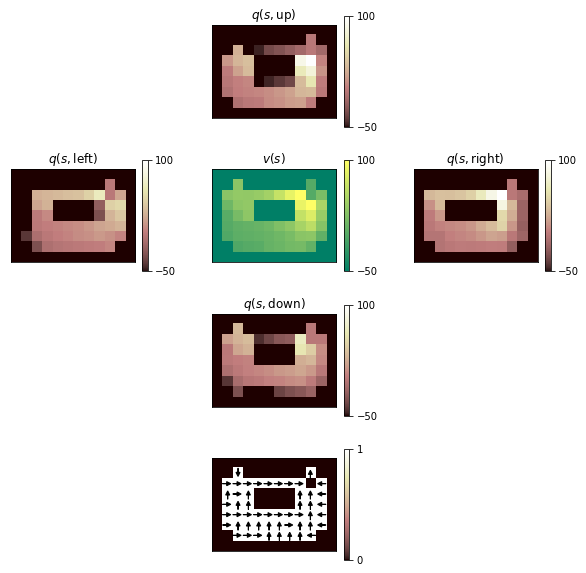

In [11]:
# Double Q-learning
# Do not modify this cell.
def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)
def target_policy(q, a):
  # Place equal probability on all actions that achieve the `max` value.
  # This is equivalent to `return np.eye(len(q))[np.argmax(q)]` for Q-learning
  # But results in slightly lower variance updates for double Q.
  max_q = np.max(q)
  pi = np.array([1. if qi == max_q else 0. for qi in q])
  return pi / sum(pi)

learned_qs = []
for _ in range(5):
  grid = Grid()
  agent = GeneralQ(grid._layout.size, 4, grid.get_obs(), target_policy, 
                   behaviour_policy, double=True, step_size=step_size)
  run_experiment(grid, agent, int(1e5))
  learned_qs.append(agent.q_values.reshape(grid._layout.shape + (4,)))
  
avg_qs = sum(learned_qs)/len(learned_qs)
plot_action_values(GRID_LAYOUT, avg_qs, vmin=-50, vmax=100)

## Task 2 - Analyse results

Consider the greedy policy with respect to the estimated values learned by each of the four agents.

**Task 2.1** How and why do the policies found by Q-learning, Sarsa, Expected Sarsa, and double Q-learning differ? Explain notable qualitative differences in at most four sentences.

> - **Q-learning**: The value function ($v(s)$) of the Q-learning algorithm looks more effective on the upper half of the grid that it seems to be bright and explore/learn towards yellow (goal).

> - **Sarsa**: The algorithm of Sarsa shows that the path goes around the middle of the rectangle (wall) in the most cases, which means the algorithm would slowly approach the goal and surely reach the goal.

> - **Expected Sarsa**: Although the algorithm of expected Sarsa seems to be significantly similar to the Sarsa and they represent the same path as shown on the bottom side of each figure, the expected Sarsa looks smoother than the Sarsa, which means the values do not rapidly/dramatically change.

> - **Double Q-learning**: The algorithm of double Q-learning finds a more efficient path than other algorithms in many cases and obtains higher rewards that are more balanced than other algorithms, as shown in the grid, which means that the performance is good not only in the middle region but also at close to the wall.

**Task 2.2** Which of the algorithms, out of Q-learning, Sarsa, Expected Sarsa, and double Q-learning with the learning parameters (exploration, step size) as discussed above, will *in general* yield higher returns on average during learning?  You are allowed to specify a partial (rather than a full) ordering over the algorithms, but try to be as specfic as you can. Explain your answer in at most four sentences.

> Specify a partial ordering over the algorithms = **1st** : Expected Sarsa, **2nd** : Sarsa, **3rd** : Double Q-learning, **4th** : Q-learning

> The algorithms of Q-learning and Double Q-learning can achieve good results by choosing an action that can get a good Q-value for the action. However, it can be highly possible to have a state that goes to the wall if the policy is stochastic, such as epsilon greedy. On the other hand, Sarsa and Expected Sarsa are likely to be relatively stable because they update the values by exploring all the overall Q-value and tries to get higher rewards, which means it avoids close to the wall. Therefore, these ordering can be justified by this question based on the above qualitatively answers and these mentioned.

## Experiment 2: Run the cells below

This will train Q-learning and double Q-learning agents on the stochastic version of the Grid problem.

In the noisy version, a zero-mean Gaussian is added to all rewards.  

The variance of this noise is higher the further to the left you go, and the further down.

The agents will be trained  with a step size $\alpha=\frac{1}{10}$ and $\epsilon$-greedy behaviour, with $\epsilon=\frac{1}{4}$.

The plots will show action values for each of the actions, as well as a state value defined by $v(s) = \max_a q(s, a)$.

In [12]:
# Agent settings.
# Do not modify this cell.
epsilon = 0.25
step_size = 0.1

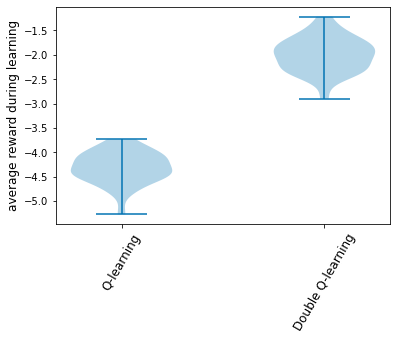

In [13]:
# Q-learning and double Q-learning.
# Do not modify this cell.

def target_policy(q, a):
  max_q = np.max(q)
  pi = np.array([1. if qi == max_q else 0. for qi in q])
  return pi / sum(pi)

def behaviour_policy(q):
  return epsilon_greedy(q, epsilon)

mean_reward_q_learning = []
mean_reward_double_q_learning = []
for _ in range(30):
  grid = Grid(noisy=True)
  q_agent = GeneralQ(
      grid._layout.size, 4, grid.get_obs(),
      target_policy, behaviour_policy, double=False, step_size=step_size)
  dq_agent = GeneralQ(
      grid._layout.size, 4, grid.get_obs(),
      target_policy, behaviour_policy, double=True, step_size=step_size)
  mean_reward_q_learning.append(run_experiment(grid, q_agent, int(2e5)))
  mean_reward_double_q_learning.append(run_experiment(grid, dq_agent, int(2e5)))

plt.violinplot([mean_reward_q_learning, mean_reward_double_q_learning])
plt.xticks([1, 2], ["Q-learning", "Double Q-learning"], rotation=60, size=12)
plt.ylabel("average reward during learning", size=12)
ax = plt.gca()
ax.grid(0)

## Task 3 - Analyse results 

Which among Q-learning and Double Q-learning has a higher average reward? Explain why, discussing at least a) the dynamics of the algorithm, b) how this affects behaviour, and c) why the behaviour yields higher rewards for one algorithm rather than the other. Be concise.

> The Q-learning is a popular reinforcement learning algorithm based on the principle of the Markov Decision Process (MDP) in general. The Q-learning uses a single estimator, which means that it estimates the value of the next state. Moreover, the Q-learning algorithm shows that overestimations of the action-values can be generated because of using stochastic MDPs and maximum action-values so that the performance would be poor. On the other hand, the Double Q-learning uses a double estimator, which means that it stores a couple of Q function, such as $Q_{a}$ and $Q_{b}$. One of the Q function is updated a value for the next state from the other and this algorithm does not inefficient using data because both Q functions are all used to choose an action. Therefore, the Double Q-learning prevents the overestimations of the action values based on using the two Q functions. A paper [1] proved that even if the Double Q-learning sometimes occurs underestimations the action values, it yields higher rewards and provide better performance than the Q-learning.

> [1] H. V. Hasselt, "Double Q-learning", *Multi-agent and Adaptive Computation Group*, Centrum Wiskunde & Informatica, 2010.

## Task 4 - Target Q-learning 

Consider a new algorithm which we will refer to as **target Q-learning**. The target Q-learning algorithm applies Q-learning updates in the form 
$\ \ q(S_t, A_t) \leftarrow R_{t+1} + \gamma \max_a q'(S_{t+1}, a) \ \ $  
where the values $q'$ have been pre-trained by running $\epsilon$-greedy Expected Sarsa, and are then held fixed throughout training.

We can now imagine now to train both Q-learning and target Q-learning on the deterministic Grid problem.  In both Q-learning and target Q-learning the behaviour policy will select actions based on the same $\epsilon$-greedy policy that was used to pre-train the $q'$ values, but using the current action-value estimates (not the fixed target values $q'$).

Explain concisely which of the two algorithms will perform better and why. (If you're tempted to answer 'it depends', be sure to be clear what you think it depends on, and why. Don't be vague: point could be subtracted for including irrelevant or false statements, even if the correct answer is also given.)

> The Q-learning algorithm can basically use to determine optimal policy by updating Q values based on empirical data. $\epsilon$ greedy action selection has been used as a stochastic policy to select an action that maximises the Q function with 1-$\epsilon$ probability. Various actions are randomly explored in the early stages of learning. As learning progresses, good action is taken according to the action-value function that has become more reliable. On the other hand, the target Q-learning is a bootstrap method, and the target value is determined based on the Bellman equation. Furthermore, it might be improved that the target policy cannot be inadvertently updated immediately based on the concept of a deadly triad if the fixed target values are not used. However, for both algorithms, dynamic changes make the learning process unstable, and the Q function likely to be divergence if it applies to approximation or nonlinear function. A paper [2] proved that the target Q-learning is more efficient and less divergence than the Q-learning if bootstrapping on separate networks.

> $q(S_t, A_t) \leftarrow R_{t+1} + \gamma \max_a q'(S_{t+1}, a)$ : self._q[self._s, self.last_action] = reward + discount * np.dot(self._q[next_state], self._target_policy(self._q[next_state], action) 

> [2] H. v. Hasselt, Y. Doron, F. Strub, M. Hessel, N. Sonnerat, J. Modayil, "Deep Reinforcement Learning and the Deadly Triad", *Google DeepMind*, Dec, 2018